# MNIST with ConvNets

> <span style="color:gray">
Original [Theano/Lasagne tutorial](https://github.com/DeepLearningDTU/nvidia_deep_learning_summercamp_2016/blob/master/lab1/lab1_FFN.ipynb) by 
Lars Maaløe ([larsmaaloee](https://github.com/larsmaaloee)),
Søren Kaae Sønderby ([skaae](https://github.com/skaae)), and 
Casper Sønderby ([casperkaae](https://github.com/casperkaae)). 
Converted to TensorFlow by 
Alexander R. Johansen ([alrojo](https://github.com/alrojo)), 
and updated by 
Toke Faurby ([faur](https://github.com/Faur)).
</span>


In this lab we will solve the MNIST problem again, but this time with convolutional networks.
You will get a to try stacking of convolutional layers, max pooling and strided convolutions which are all important techniques in current convolutional layers network architectures.


### Dependancies and supporting functions


Loading dependancies and supporting functions by running the code block below.

In [1]:
from __future__ import absolute_import, division, print_function 

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
# import sklearn.datasets
import tensorflow as tf
import os
import sys
sys.path.append(os.path.join('.', '..')) 
import utils_ as utils



In [2]:
import datetime
timestr = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
logdir = os.path.join('.', 'logdir', timestr)

## The MNIST data set

We load the MNIST dataset.
This time the data is keept as images (`shape = [28, 28, 1]`), and not flattended into vectors (`shape = [784]`).
This allows the convolutional network to take advantage of the structure of the data

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz

Information on dataset
    ----------------------
Training size:	 55000
Test size	 10000
Validation size	 5000

Data summaries
Image shape		 (28, 28, 1)
Image type		 <class 'numpy.ndarray'>
Image min/max value	 0.0 / 1.0
Label shape		 (10,)
Label type		 <class 'numpy.float64'>


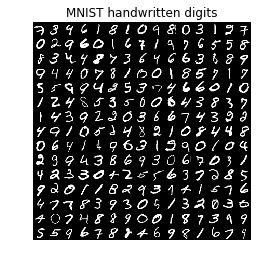

In [3]:
# Load data (download if you haven't already)
from tensorflow.examples.tutorials.mnist import input_data
mnist_data = input_data.read_data_sets('MNIST_data', 
                                       one_hot=True,   # Convert the labels into one hot encoding
                                       dtype='float32', # rescale images to `[0, 1]`
                                       reshape=False, # Don't flatten the images to vectors
                                      )

## Print dataset statistics and visualize
print('')
utils.mnist_summary(mnist_data)



## Building the model

We will use Keras layers, which are documented [here](https://keras.io/layers/about-keras-layers/)

In [5]:
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.contrib.layers import flatten # We use this flatten, as it works better than 
                                              # the Keras 'Flatten' for some reason


Using TensorFlow backend.


In [5]:
tf.reset_default_graph()

num_classes = 10
height, width, nchannels = 28, 28, 1
padding = 'same'

filters_1 = 16
kernel_size_1 = (5,5)
pool_size_1 = (2,2)

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
    x = flatten(x)
    print('Flatten \t', x.get_shape())


with tf.variable_scope('output_layer'):
    denseOut = Dense(units=num_classes, activation='softmax')
    
    y = denseOut(x)
    print('denseOut\t', y.get_shape())    

print('Model consits of ', utils.num_params(), 'trainable parameters.')

Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 28, 28, 16)
pool1 		 (?, 14, 14, 16)
Flatten 	 (?, 3136)
denseOut	 (?, 10)
Model consits of  31786 trainable parameters.


In [6]:
## Launch TensorBoard, and visualize the TF graph
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    sess.run(tf.global_variables_initializer())
    tf.summary.FileWriter(os.path.join(logdir, '3EXE_1'), sess.graph)

In [9]:
with tf.variable_scope('loss'):
    # computing cross entropy per sample
    cross_entropy = -tf.reduce_sum(y_pl * tf.log(y+1e-8), reduction_indices=[1])

    # averaging over samples
    cross_entropy = tf.reduce_mean(cross_entropy)

    
with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

    # applying the gradients
    train_op = optimizer.minimize(cross_entropy)

    
with tf.variable_scope('performance'):
    # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
    correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))

    # averaging the one-hot encoded vector
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [8]:
#Test the forward pass
x_batch, y_batch = mnist_data.train.next_batch(4)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
# with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    y_pred = sess.run(fetches=y, feed_dict={x_pl: x_batch})

assert y_pred.shape == y_batch.shape, "ERROR the output shape is not as expected!" \
        + " Output shape should be " + str(y.shape) + ' but was ' + str(y_pred.shape)

print('Forward pass successful!')

Forward pass successful!


## Training

In [9]:
#Training Loop
batch_size = 100
max_epochs = 10


valid_loss, valid_accuracy = [], []
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Begin training loop')

    try:
        while mnist_data.train.epochs_completed < max_epochs:
            _train_loss, _train_accuracy = [], []
            
            ## Run train op
            x_batch, y_batch = mnist_data.train.next_batch(batch_size)
            fetches_train = [train_op, cross_entropy, accuracy]
            feed_dict_train = {x_pl: x_batch, y_pl: y_batch}
            _, _loss, _acc = sess.run(fetches_train, feed_dict_train)
            
            _train_loss.append(_loss)
            _train_accuracy.append(_acc)
            

            ## Compute validation loss and accuracy
            if mnist_data.train.epochs_completed % 1 == 0 \
                    and mnist_data.train._index_in_epoch <= batch_size:
                train_loss.append(np.mean(_train_loss))
                train_accuracy.append(np.mean(_train_accuracy))

                fetches_valid = [cross_entropy, accuracy]
                
                feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}
                _loss, _acc = sess.run(fetches_valid, feed_dict_valid)
                
                valid_loss.append(_loss)
                valid_accuracy.append(_acc)
                print("Epoch {} : Train Loss {:6.3f}, Train acc {:6.3f},  Valid loss {:6.3f},  Valid acc {:6.3f}".format(
                    mnist_data.train.epochs_completed, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
        
        
        test_epoch = mnist_data.test.epochs_completed
        while mnist_data.test.epochs_completed == test_epoch:
            x_batch, y_batch = mnist_data.test.next_batch(batch_size)
            feed_dict_test = {x_pl: x_batch, y_pl: y_batch}
            _loss, _acc = sess.run(fetches_valid, feed_dict_test)
            test_loss.append(_loss)
            test_accuracy.append(_acc)
        print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(
                    np.mean(test_loss), np.mean(test_accuracy)))


    except KeyboardInterrupt:
        pass


Begin training loop
Epoch 1 : Train Loss  0.083, Train acc  0.970,  Valid loss  0.137,  Valid acc  0.961
Epoch 2 : Train Loss  0.149, Train acc  0.960,  Valid loss  0.088,  Valid acc  0.974
Epoch 3 : Train Loss  0.016, Train acc  1.000,  Valid loss  0.073,  Valid acc  0.978
Epoch 4 : Train Loss  0.052, Train acc  0.980,  Valid loss  0.069,  Valid acc  0.979
Epoch 5 : Train Loss  0.025, Train acc  0.990,  Valid loss  0.058,  Valid acc  0.982
Epoch 6 : Train Loss  0.033, Train acc  1.000,  Valid loss  0.066,  Valid acc  0.980
Epoch 7 : Train Loss  0.061, Train acc  0.970,  Valid loss  0.062,  Valid acc  0.982
Epoch 8 : Train Loss  0.043, Train acc  0.990,  Valid loss  0.058,  Valid acc  0.983
Epoch 9 : Train Loss  0.011, Train acc  1.000,  Valid loss  0.055,  Valid acc  0.984
Epoch 10 : Train Loss  0.030, Train acc  0.980,  Valid loss  0.059,  Valid acc  0.982
Test Loss  0.053, Test acc  0.982


(<matplotlib.text.Text at 0x1c3b1e4ce48>,
 (0.75, 1.03))

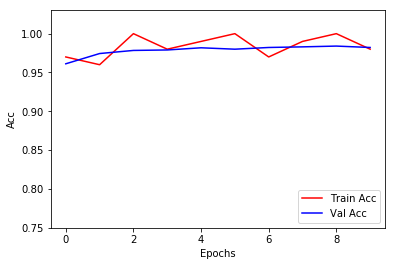

In [10]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_accuracy,'r', epoch, valid_accuracy,'b')
plt.legend(['Train Acc','Val Acc'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

# Assignments

#### <span style="color:red"> EXE 1.1 </span> Manual calculations

![](images/conv_exe.png)



1. Manually convolve the input, and compute the convolved features. No padding and no strieds.
1. Perform `2x2` max pooling on the convolved features. Stride of 2.

___

<span style="color:blue"> Answer: </span>





# 1:
First window:
$$ 2+6 = 8 $$
Second window:
$$ 2+1+4+4+9 = 20 $$
Third window:
$$ 2+4+2+6 = 14 $$
Fourth window:
$$ 4+2+6+4+9 = 25 $$
I.e. the 2x2 convolved feature is:
$$
Y = \begin{bmatrix}
       8 & 20  \\[0.3em]
       14 & 25    \\[0.3em]
     \end{bmatrix}
$$
# 2:
As the feature space currently is 2x2, the result of 2x2 max pooling w/o any zero padding is a scalar of 
$$ \textrm{max}(Y) = 25 $$
Zeropadding the feature space would give the following window:
$$
Y_0 = \begin{bmatrix}
    0 & 0 & 0 & 0 \\[0.3em]
    0 & 8 & 20 & 0  \\[0.3em]
    0 & 14 & 25 & 0    \\[0.3em]
    0 & 0 & 0 & 0
     \end{bmatrix}
$$
and by performing 2x2 max pooling with a stride of 2 would return the original feature space $ Y $


#### <span style="color:red"> EXE 1.2 </span> Reducing the resolution
One of the important features of convolutional networks are their ability to reduce the spatial resolution, while retaining the important features.
Effectively this gives a local translational invariance and reduces the computation. 
This is most often done with **maxpooling** or by using strides.

1. Using only convolutional layers and pooling operations reduce the feature map size to `1x1xF`.
    * The number of feature maps, `F`, is up to you.

___

<span style="color:blue"> Write down what you did: </span>

``` 
Paste your code here
```


``` 
Paste the trace of the tensors shape as it is propagated through the network here
```


## Building the model

In [8]:
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)
num_classes = 10
height, width, nchannels = 28, 28, 1
padding = 'same'

filters_1 = 12
kernel_size_1 = (5,5)
pool_size_1 = (2,2)

filters_2 = 8
kernel_size_2 = (5,5)
pool_size_2 = (8,8)

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
        
with tf.variable_scope('convLayer2'):
    conv2 = Conv2D(filters_2, kernel_size_2, strides=(1,1), padding=padding, activation='relu')
    x = conv2(x)
    print('conv2 \t\t', x.get_shape())

    pool2 = MaxPooling2D(pool_size=pool_size_2, strides=None, padding=padding)
    x = pool2(x)
    print('pool2 \t\t', x.get_shape())
    x = flatten(x)
    print('Flatten \t', x.get_shape())


with tf.variable_scope('output_layer'):
    denseOut = Dense(units=num_classes, activation='softmax')
    
    y = denseOut(x)
    print('denseOut\t', y.get_shape())    

print('Model consits of ', utils.num_params(), 'trainable parameters.')

Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 28, 28, 1)
conv1 		 (?, 28, 28, 12)
pool1 		 (?, 14, 14, 12)
conv2 		 (?, 14, 14, 8)
pool2 		 (?, 2, 2, 8)
Flatten 	 (?, 32)
denseOut	 (?, 10)
Model consits of  3050 trainable parameters.


## Training

In [10]:
#Training Loop
batch_size = 100
max_epochs = 10


valid_loss, valid_accuracy = [], []
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('Begin training loop')

    try:
        while mnist_data.train.epochs_completed < max_epochs:
            _train_loss, _train_accuracy = [], []
            
            ## Run train op
            x_batch, y_batch = mnist_data.train.next_batch(batch_size)
            fetches_train = [train_op, cross_entropy, accuracy]
            feed_dict_train = {x_pl: x_batch, y_pl: y_batch}
            _, _loss, _acc = sess.run(fetches_train, feed_dict_train)
            
            _train_loss.append(_loss)
            _train_accuracy.append(_acc)
            

            ## Compute validation loss and accuracy
            if mnist_data.train.epochs_completed % 1 == 0 \
                    and mnist_data.train._index_in_epoch <= batch_size:
                train_loss.append(np.mean(_train_loss))
                train_accuracy.append(np.mean(_train_accuracy))

                fetches_valid = [cross_entropy, accuracy]
                
                feed_dict_valid = {x_pl: mnist_data.validation.images, y_pl: mnist_data.validation.labels}
                _loss, _acc = sess.run(fetches_valid, feed_dict_valid)
                
                valid_loss.append(_loss)
                valid_accuracy.append(_acc)
                print("Epoch {} : Train Loss {:6.3f}, Train acc {:6.3f},  Valid loss {:6.3f},  Valid acc {:6.3f}".format(
                    mnist_data.train.epochs_completed, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1]))
        
        
        test_epoch = mnist_data.test.epochs_completed
        while mnist_data.test.epochs_completed == test_epoch:
            x_batch, y_batch = mnist_data.test.next_batch(batch_size)
            feed_dict_test = {x_pl: x_batch, y_pl: y_batch}
            _loss, _acc = sess.run(fetches_valid, feed_dict_test)
            test_loss.append(_loss)
            test_accuracy.append(_acc)
        print('Test Loss {:6.3f}, Test acc {:6.3f}'.format(
                    np.mean(test_loss), np.mean(test_accuracy)))


    except KeyboardInterrupt:
        pass


Begin training loop
Epoch 0 : Train Loss  2.370, Train acc  0.100,  Valid loss  2.334,  Valid acc  0.097
Epoch 1 : Train Loss  0.207, Train acc  0.940,  Valid loss  0.242,  Valid acc  0.932
Epoch 2 : Train Loss  0.192, Train acc  0.930,  Valid loss  0.172,  Valid acc  0.948
Epoch 3 : Train Loss  0.199, Train acc  0.950,  Valid loss  0.129,  Valid acc  0.961
Epoch 4 : Train Loss  0.094, Train acc  0.950,  Valid loss  0.116,  Valid acc  0.964
Epoch 5 : Train Loss  0.102, Train acc  0.970,  Valid loss  0.104,  Valid acc  0.967
Epoch 6 : Train Loss  0.077, Train acc  0.970,  Valid loss  0.106,  Valid acc  0.968
Epoch 7 : Train Loss  0.208, Train acc  0.950,  Valid loss  0.099,  Valid acc  0.971
Epoch 8 : Train Loss  0.128, Train acc  0.960,  Valid loss  0.085,  Valid acc  0.973
Epoch 9 : Train Loss  0.084, Train acc  0.980,  Valid loss  0.083,  Valid acc  0.974
Epoch 10 : Train Loss  0.053, Train acc  0.980,  Valid loss  0.082,  Valid acc  0.975
Test Loss  0.070, Test acc  0.978


(<matplotlib.text.Text at 0x1f64fd86c88>,
 (0.75, 1.03))

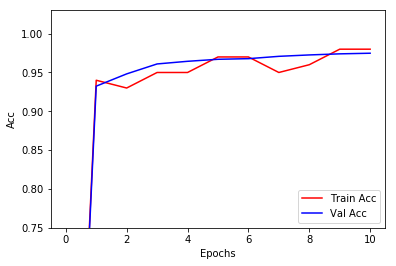

In [11]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_accuracy,'r', epoch, valid_accuracy,'b')
plt.legend(['Train Acc','Val Acc'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Acc'), plt.ylim([0.75,1.03])

#### <span style="color:red"> EXE 1.3 </span> Play around with the network.
The MNIST dataset is so easy to solve with convolutional networks that it isn't interesting to spend to much time on maximizing performance.
A more interesting question is *how few parameters can you solve it with?*

1. Try and minimize the number of parameters, while keeping validation accuracy about 95%. Try changing the

    * Number of layers
    * Number of filters
    * Kernel size
    * Pooling size
1. Once happy take note of the performance, number of parameters (printed automatically), and describe the network below.
___


<span style="color:blue"> Answer: </span>


#### <span style="color:red"> EXE 1.4 </span> Comparing dense and convolutional networks

1. Now create a densely connected network (the ones from lab 1), and see how good performance you can get with a similar number of parameters.
___

<span style="color:blue"> Describe your findings: </span>
